In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (20,7)

In [2]:
dict_months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 
               'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

macro_variables = {
    "RPI": "Real Personal Income",
    "INDPRO": "Industrial Production Index",
    "CAPUTLB00004S": "Capacity utilization: manufacturing",
    "HWIURATIO": "Help wanted to unemployed ratio",
    "UNRATE": "Unemployment rate",
    "PAYEMS": "All employees: total nonfarm ",
    "CES0600000007": "Weekly hours: goods-producing",
    "CES0600000008": "Avg. hourly earnings, goods-producing",
    "HOUST": "Housing starts",
    "PERMIT": "Housing permits",
    "DPCERA3M086SBEA": "Real consumer spending",
    "CMRMTSPLx": "Real manuf. and trade sales",
    "NAPMNOI": "ISM: new orders index",
    "AMDMNOx": "Orders for durable goods ",
    "FEDFUNDS": "Federal funds rate",
    "PPIFGS": "PPI, finished goods",
    "PPICMM": "PPI, commodities",
    "PCEPI": "PCE price index",
}

finance_variables = {
    "SP500": "S&P 500 ",
    "BAAT10Y": "10 year BAA",
    "excessreturn": "Excess Return",
    "SMB": "SMB",
    "HML": "HML",
    "aggind1": "Consumer",
    "aggind2": "Manufactory",
    "aggind3": "High Technology",
    "aggind4": "Health",
    "aggind5": "Other",
    "momentum": "momentum",
    "R15_R11": "R15_R11"
}

full_dict_variables = {}
full_dict_variables.update(macro_variables)
full_dict_variables.update(finance_variables)

In [4]:
def set_index_date(df):
    df[["year", "month"]] = df["date"].str.split(':', expand=True)
    df["day"] = 1
    df = create_date_column(df)
    return df

def create_date_column(df):
    """
    takes dataframe with columns year, month, day
    returns dataframe with column dates as timestamp
    """

    dates_df = df[['year', 'month', 'day']]
    df['date'] = pd.to_datetime(dates_df)
    df = df.drop(['year', 'month', 'day'], axis=1)
    df = df.set_index('date')
    return df

def process_initial_data(df):
        df["month"] = df["Date"].astype(str).str[:3]
        df["year"] = df["Date"].astype(str).str[3:]
        df["month"] = df["month"].replace(dict_months)
        df["day"] = 1
        df = create_date_column(df)
        df = df.drop(["Date"], axis=1)

        for column in df.columns:
            df[column] = df[column].astype("float")
        return df

In [5]:
path_full_data = "/Users/victorgraff/Documents/2022:2023 ENSAE/Cours/S1/Macroeconometrics ML/Project/datasets/from Audin/dataverse_files/Matlabimplementation/data.csv"

full_data = pd.read_csv(path_full_data)
full_data = process_initial_data(full_data)

In [6]:
full_data.tail()

,PAYEMS,INDPRO,CAPUTLB00004S,HWIURATIO,UNRATE,RPI,CES0600000007,HOUST,PERMIT,DPCERA3M086SBEA,CMRMTSPLx,NAPMNOI,AMDMNOx,CES0600000008,PPIFGS,PPICMM,PCEPI,FEDFUNDS,SP500,BAAT10Y,excessreturn,SMB,HML,momentum,R15_R11,aggind1,aggind2,aggind3,aggind4,aggind5
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-03-01,137964.0,103.1059,76.8475,0.831568,6.6,13456.8,41.5,950.0,1000.0,110.728,1167463.0,55.1,238420.0,21.49,199.7,195.3,108.292,0.08,1863.52,2.34,0.43,-1.81,4.60,-3.25,5.05,0.68,1.39,-0.68,-2.56,2.30
2014-04-01,138268.0,103.1885,76.9611,0.894596,6.2,13460.4,41.4,1063.0,1059.0,110.661,1170752.0,55.1,240481.0,21.51,200.8,195.4,108.523,0.09,1864.26,2.19,-0.19,-4.17,1.62,-3.90,4.85,-0.04,2.96,-0.88,-0.30,-1.55
2014-05-01,138497.0,103.6839,77.1180,0.884028,6.3,13472.7,41.5,984.0,1005.0,110.754,1174460.0,56.9,238337.0,21.55,200.9,195.6,108.790,0.09,1889.77,2.20,2.06,-1.84,-0.38,1.02,2.76,1.79,0.96,3.56,1.89,1.76
2014-06-01,138764.0,104.1050,77.3048,0.940548,6.1,13497.4,41.6,909.0,973.0,111.049,1178996.0,58.9,244841.0,21.57,202.3,197.6,109.034,0.10,1947.09,2.20,2.61,2.94,-0.60,0.70,-2.18,1.55,3.00,2.69,2.86,2.08
2014-07-01,139007.0,104.4671,77.7926,0.917496,6.2,13517.2,41.6,1098.0,1057.0,111.159,1187474.0,63.4,299862.0,21.61,202.3,201.0,109.125,0.09,1973.10,2.19,-2.04,-4.25,0.04,-0.26,4.42,-3.26,-4.34,0.38,-0.33,-2.12


In [7]:
u_data=(full_data-full_data.min())/(full_data.max()-full_data.min())
u_data = u_data.rename(columns=full_dict_variables)
u_data.head(3)

,All employees: total nonfarm,Industrial Production Index,Capacity utilization: manufacturing,Help wanted to unemployed ratio,Unemployment rate,Real Personal Income,Weekly hours: goods-producing,Housing starts,Housing permits,Real consumer spending,Real manuf. and trade sales,ISM: new orders index,Orders for durable goods,"Avg. hourly earnings, goods-producing","PPI, finished goods","PPI, commodities",PCE price index,Federal funds rate,S&P 500,10 year BAA,Excess Return,SMB,HML,momentum,R15_R11,Consumer,Manufactory,High Technology,Health,Other
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960-01-01,0.008402,0.025080,0.780759,0.288755,0.243243,0.000000,0.636364,0.487103,0.303778,0.000000,0.020410,0.817829,0.004643,0.000000,0.000000,0.006899,0.000000,0.205991,0.002240,0.057692,0.413320,0.480523,0.584752,0.587047,0.741084,0.373610,0.360032,0.402533,0.282313,0.437700
1960-02-01,0.011199,0.022475,0.746452,0.326923,0.189189,0.000141,0.568182,0.508433,0.301679,0.000900,0.024503,0.567829,0.004473,0.000516,0.000000,0.007244,0.000185,0.204940,0.001068,0.097902,0.620488,0.442337,0.410067,0.725831,0.687589,0.556886,0.543855,0.687779,0.414766,0.538795
1960-03-01,0.010556,0.019869,0.697068,0.254493,0.270270,0.000530,0.522727,0.312996,0.231899,0.003816,0.016771,0.562016,0.003912,0.001031,0.001773,0.006899,0.000294,0.198108,0.000672,0.124126,0.549314,0.415941,0.380089,0.679947,0.614123,0.478614,0.496324,0.553601,0.441577,0.485395


## PCA

In [8]:
pca = PCA(n_components=5).fit(u_data)

In [9]:
pca.explained_variance_ratio_

array([0.69600625, 0.0972381 , 0.05071925, 0.04584903, 0.03152974])

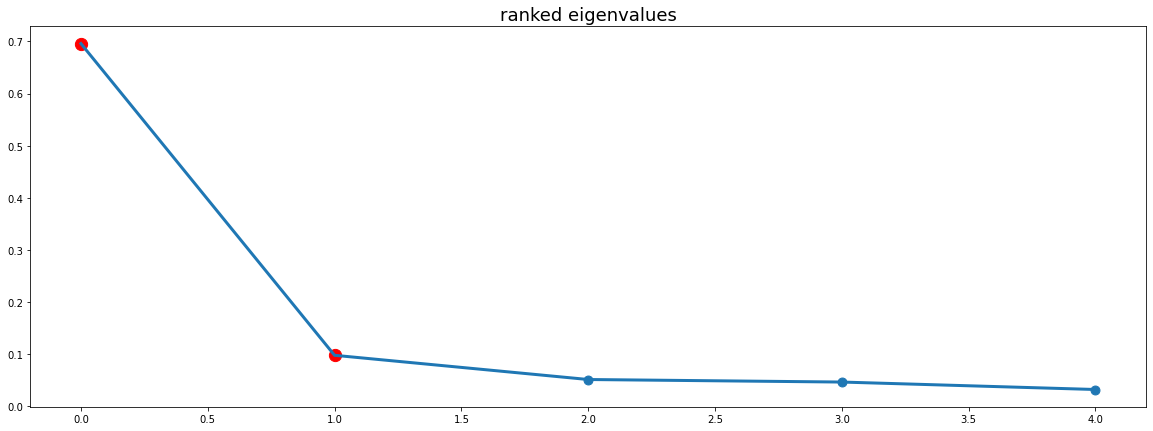

In [11]:
plt.plot(pca.explained_variance_ratio_, linewidth=3)
plt.scatter(np.linspace(0, 4, 5), pca.explained_variance_ratio_, s=80)
plt.title("ranked eigenvalues", fontsize=18)
#plt.plot([1.2, 1.2], [0, .6], "r")
plt.scatter(np.linspace(0, 1, 2), pca.explained_variance_ratio_[:2], s=150, color="r")

In [14]:
pca.explained_variance_ratio_[:2]

array([0.69600625, 0.0972381 ])

In [13]:
pca.explained_variance_ratio_[:2].sum()

0.7932443447118204

In [99]:
pca = PCA(n_components=2).fit(u_data)

In [101]:
np.sum(pca.explained_variance_ratio_)

0.7932443447118205

In [102]:
scores = pca.transform(u_data)
reconstruct = u_data + pca.inverse_transform(scores) - u_data
resid_pca = u_data - reconstruct

Text(0.5, 1.0, 'Factors computed by PCA')

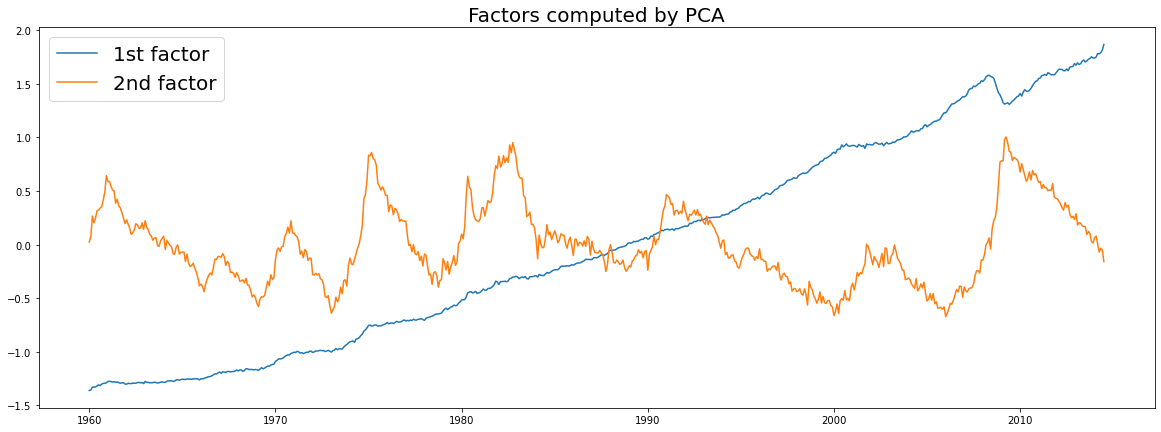

In [109]:
plt.plot(u_data.index, pca.transform(u_data)[:, 0], label="1st factor")
plt.plot(u_data.index, pca.transform(u_data)[:, 1], label="2nd factor")
plt.legend(fontsize=20)
plt.title("Factors computed by PCA", fontsize=20)

## Factors model

In [15]:
factors = dict()
for macro_variable in list(macro_variables.values()):
    factors[macro_variable] = ["Macro"]
for finance_variable in list(finance_variables.values()):
    factors[finance_variable] = ["Finance"]

In [21]:
factor_model = DynamicFactorMQ(u_data,
                    factors=factors,
                    factor_orders = {'Macro': 1, "Finance": 1},
                    idiosyncratic_ar1=True,
                    standardize=False)

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [22]:
model_results = factor_model.fit(disp=30)

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


EM start iterations, llf=-1.1515e+05
EM iteration 30, llf=12494, convergence criterion=4.5767e-05
EM iteration 60, llf=12503, convergence criterion=1.344e-05
EM iteration 90, llf=12507, convergence criterion=1.0843e-05
EM iteration 120, llf=13225, convergence criterion=0.00092934
EM iteration 150, llf=13274, convergence criterion=2.8938e-06
EM iteration 180, llf=13275, convergence criterion=2.5172e-06
EM iteration 210, llf=13276, convergence criterion=2.2706e-06
EM iteration 240, llf=13277, convergence criterion=2.0944e-06
EM iteration 270, llf=13278, convergence criterion=1.96e-06
EM iteration 300, llf=13278, convergence criterion=1.8521e-06
EM iteration 330, llf=13279, convergence criterion=1.7622e-06
EM iteration 360, llf=13280, convergence criterion=1.685e-06
EM iteration 390, llf=13280, convergence criterion=1.6172e-06
EM iteration 420, llf=13281, convergence criterion=1.5565e-06
EM iteration 450, llf=13282, convergence criterion=1.5015e-06
EM iteration 480, llf=13282, convergence

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2680: UserWarning: EM reached maximum number of iterations (500), without achieving convergence: llf=13283, convergence criterion=1.4194e-06 (while specified tolerance was 1e-06)
  warn(f'EM reached maximum number of iterations ({maxiter}),'


EM reached maximum number of iterations (500), without achieving convergence: llf=13283, convergence criterion=1.4194e-06 (while specified tolerance was 1e-06)


Text(0.5, 1.0, 'Factors computed by DFM')

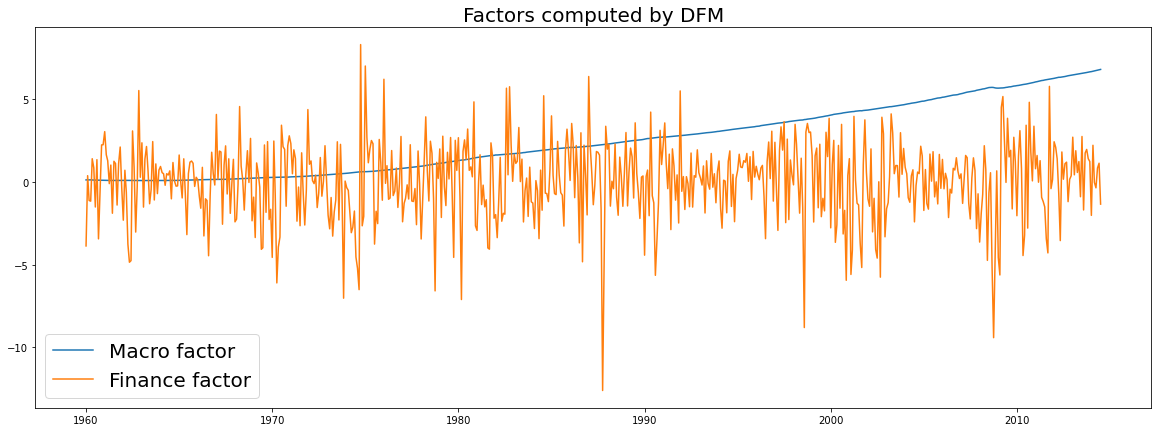

In [110]:
plt.plot(u_data.index, -model_results.factors.smoothed["Macro"].values, label="Macro factor")
plt.plot(u_data.index, -model_results.factors.smoothed["Finance"].values, label="Finance factor")
plt.legend(fontsize=20)
plt.title("Factors computed by DFM", fontsize=20)

## Comparison of models

In [108]:
print(f"Residuals of DFM on global dataset: {np.round(np.abs(model_results.resid).sum().sum(), 2)}")
print(f"Residuals of PCA on global dataset: {np.round(np.abs(resid_pca).sum().sum(), 2)}")

Residuals of DFM on global dataset: 5876.73
Residuals of PCA on global dataset: 1335.13


Text(0.5, 1.0, 'Representation of unemplyment rate by each model')

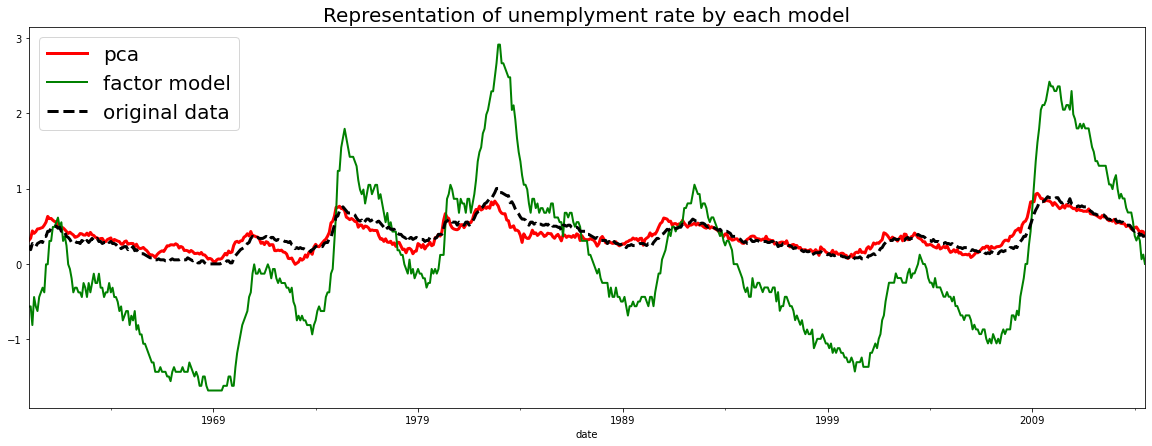

In [107]:
reconstruct["Unemployment rate"].plot(label="pca", linewidth = 3, color="red")
model_results.fittedvalues["Unemployment rate"].plot(label="factor model", linewidth = 2, color="green")
u_data["Unemployment rate"].plot(label="original data", color="black", linewidth = 3, style="--")
plt.legend(fontsize=20)
plt.title("Representation of unemplyment rate by each model", fontsize=20)

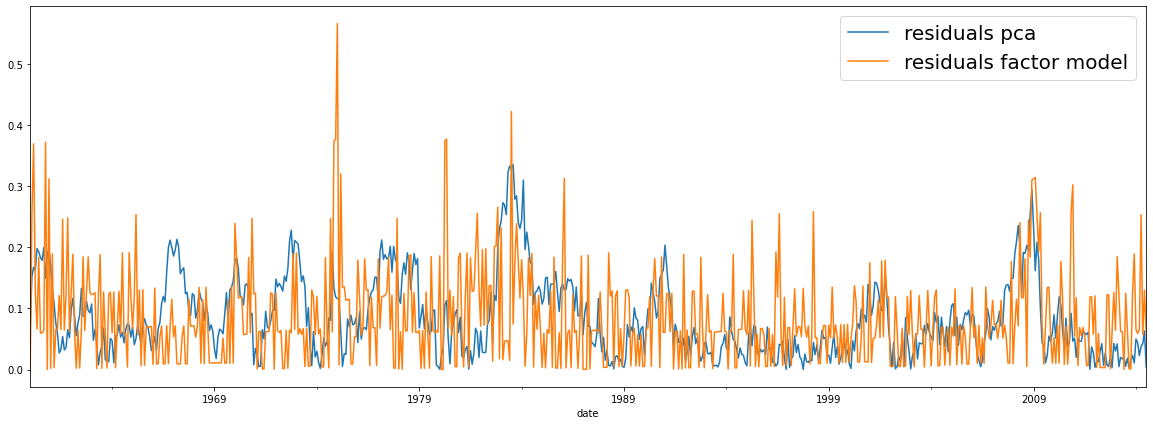

In [112]:
np.abs(resid_pca["Unemployment rate"]).plot(label="residuals pca")
np.abs(model_results.resid["Unemployment rate"]).plot(label="residuals factor model")
plt.legend(fontsize=20)